## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, I import my libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, I read in the `ab_data.csv` data and store it in `df`.

a. Read in the dataset and take a look at the top few rows:

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Shape of dataset.

In [4]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
df['user_id'][df['converted'] == 1].count() / df['user_id'].count()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
sum(df.isnull().sum())

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, I cannot be sure if this row truly received the new or old page.  I elect to remove these data rows because they constitute a small portion of the data set, and I have no way of knowing the true value for the row.

a. I store my new dataframe in **df2**.

In [9]:
df2 = df.drop(df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].index)

In [10]:
df2 = df2.drop(df2[(df2['group'] == 'control') & (df2['landing_page'] == 'new_page')].index)

In [11]:
df2.count()

user_id         290585
timestamp       290585
group           290585
landing_page    290585
converted       290585
dtype: int64

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` I analyze **df2**

a. How many unique **user_id**s are in **df2**?

In [13]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  I locate it.

In [14]:
df2[df2.duplicated(subset=['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. This is the row information for the repeat **user_id**

In [15]:
df2[df2.duplicated(subset=['user_id'], keep='first')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. I remove the second row with a duplicate **user_id** but keep my dataframe as **df2**.

In [16]:
df2 = df2.drop_duplicates(subset=['user_id'], keep='first')

In [17]:
df2.shape

(290584, 5)

`4.` Basic insight into the probability of being converted

a. The probability of an individual converting regardless of the page they receive

In [18]:
df2['converted'][df2['converted'] == 1].sum() / len(df2)

0.11959708724499628

b. Given that an individual was in the `control` group, the probability they converted

In [19]:
df2['group'][(df2['group'] == 'control') & (df2['converted'] == 1)].count() / df2['group'][df2['group'] == 'control'].count()

0.1203863045004612

c. Given that an individual was in the `treatment` group, the probability they converted

In [20]:
df2['group'][(df2['group'] == 'treatment') & (df2['converted'] == 1)].count() / df2['group'][df2['group'] == 'treatment'].count()

0.11880806551510564

d. The probability that an individual received the new page

In [21]:
df2['landing_page'][df2['landing_page'] == 'new_page'].count() / len(df2)

0.50006194422266881

e. Initial insights on the evidence that one page leads to more conversions:

**The two groups have very similar conversion rates.  Since they're both from data sets with more than 100,000 users, it seems unlikely to me that one group quantifiably led to more conversions than the other.**

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do I run to render a decision that neither page is better than another?

These questions are the difficult parts associated with A/B tests in general.


`1.` For now, I consider I need to make the decision just based on all the data provided.  If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, my null and alternative hypotheses are below:

**$H_{0} : p_{new} - p_{old }\leq 0$**

**$H_{A} : p_{new} - p_{old}> 0$**

$\alpha = 0.05$

`2.` I assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

I perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

I use the cells below to provide the necessary parts of this simulation.<br><br>

a. The **convert rate** for $p_{new}$ under the null

In [22]:
df2['converted'][df2['converted'] == 1].sum() / len(df2)

0.11959708724499628

b. The **convert rate** for $p_{old}$ under the null

In [23]:
df2['converted'][df2['converted'] == 1].sum() / len(df2)

0.11959708724499628

c. $n_{new}$

In [24]:
df2['group'][df2['group'] == 'treatment'].count()

145310

d. $n_{old}$

In [25]:
df2['group'][df2['group'] == 'control'].count()

145274

e. I simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  I store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.choice([0,1], size = (145310, 1) , p =[(1-0.11959708724499628),0.11959708724499628])

In [27]:
new_page_converted.mean()

0.119000757002271

f. I simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.choice([0,1], size = (145274, 1) , p =[(1-0.11959708724499628),0.11959708724499628])

In [29]:
old_page_converted.mean()

0.12070983107782535

g. I find $p_{new}$ - $p_{old}$ for my simulated values from part (e) and (f).

In [30]:
new_page_converted.mean() - old_page_converted.mean()

-0.0017090740755543454

h. I simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one I calculated in parts **a. through g.** above.  I store all 10,000 values in **p_diffs**.

In [31]:
p_diffs = []
for _ in range (10000):
    newsample = np.random.choice([0,1], size = (145310, 1) , p =[(1-0.11959708724499628),0.11959708724499628])
    oldsample = np.random.choice([0,1], size = (145274, 1) , p =[(1-0.11959708724499628),0.11959708724499628])
    mean_new = newsample.mean()
    mean_old = oldsample.mean()
    p_diffs.append(mean_new - mean_old)

i. I plot a histogram of the **p_diffs**.  Does this plot look how I expected it to?

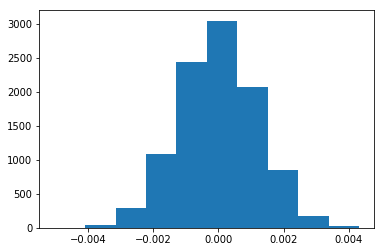

In [32]:
plt.hist(p_diffs);

**Yes, this plot looks as expected.  I expected a normal distribution centered around 0.**

j. I investigate what proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [33]:
obs_diff = (df2['group'][(df2['group'] == 'treatment') & (df2['converted'] == 1)].count() / df2['group'][df2['group'] == 'treatment'].count() - df2['group'][(df2['group'] == 'control') & (df2['converted'] == 1)].count() / df2['group'][df2['group'] == 'control'].count())
obs_diff

-0.0015782389853555567

In [34]:
(p_diffs > obs_diff).mean()

0.90369999999999995

k. I explain what I just computed in part **j.**.

**In part j, I computed the $\alpha$ value, which is the Type 1 error rate.  In our study design, we stated that we would reject the null hypothesis if this value were below 0.05.  However, since it is above 0.05, we fail to reject the null hypothesis.  We do not have sufficient evidence to suggest that the new landing page converts more users than the old landing page.**

l. I could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [35]:
import statsmodels.api as sm

convert_old = df2['group'][(df2['group'] == 'control') & (df2['converted'] == 1)].count()
convert_new = df2['group'][(df2['group'] == 'treatment') & (df2['converted'] == 1)].count()
n_old = df2['group'][df2['group'] == 'control'].count()
n_new = df2['group'][df2['group'] == 'treatment'].count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. I now use `stats.proportions_ztest` to compute my test statistic and p-value.

In [36]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. I look at what the z-score and p-value I just computed mean for the conversion rates of the old and new pages.  Secondly, I examine if this statistical method aligns with the findings in parts **j.** and **k.**.

**The p-value means that given that the null hypothesis is true, there is a 90.5% chance that the conversion rates we collected for the new page are less than or equal to those of the old page.  The z-score includes the same information but expresses it in terms of standard deviations.**

**The p-value found using a traditional z-test and the interpretation of that p-value agrees with the findings in parts j and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, I will show that the result I acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, I will use the following type of regression.

**Logistic**

b. The goal is to use **statsmodels** to fit the regression model I specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, I first need to create a column for the intercept, and create a dummy variable column for which page each user received.  I add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2[['ab_page', 'ab_page_dummy']] = pd.get_dummies(df2['landing_page'])

In [38]:
df2 = df2.drop(['ab_page_dummy'], axis=1)

In [39]:
df2['intercept'] = 1

In [40]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. I use **statsmodels** to import my regression model.  I instantiate the model and fit the model using the two columns I created in part **b.** to predict whether or not an individual converts.

In [41]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 18 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        19:13:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. I provide the summary of my model below and use it as necessary to answer the following research questions

In [42]:
1/np.exp(-0.0150)

1.0151130646157189

**The old page is 1.5% more likely to produce a conversion than the new page.  However, this difference is not statistically significant.**

e. The p-value associated with **ab_page** above is different from the findings in **Part II**.  Why?

**The p-value of 0.19 in the logistic regression differs from our one-sided z-test p-value above because the logistic regression p-value is using a two-sided z-test**

f. Now, I consider other things that might influence whether or not an individual converts.

**Adding additional factors into the regression model is something of a trade-off.  With additional factors, we may find significantly increased predictive capacity, and if we do, we should likely include this additional factor.  However, we may find that the additional factor doesn't increase our predictive capacity that much or at all while it adds a degree of complexity and difficulty to interpret.  If the additional factor doesn't increase our predictive capacity much, we likely want to leave it out.  No model is perfect, but some models are useful.  We need to make sure ours is still useful rather than being so complex we can't really render a useful interpretation out of it.**

g. Now along with testing if the conversion rate changes for different pages, I also add an effect based on which country a user lives in.  I test to see if country of residence has an impact on conversion.

In [43]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [44]:
df_countries['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [45]:
df3 = pd.merge(df2, df_countries, on='user_id', how='inner')
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [46]:
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])

In [47]:
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1


In [48]:
df3.shape

(290584, 11)

In [49]:
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 18 Oct 2018   Pseudo R-squ.:               2.323e-05
Time:                        19:19:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**In my opinion, it doesn't appear country had an impact on conversion.  Although Canada is close to qualifying for this position when I run the analysis with the US as my baseline, the p-value is still greater than 0.1.  Additionally, we see that CA and UK are fairly different but when the analysis is re-run to make CA as our baseline rather than the US, we have a p-value above 0.05 for UK.  So, it still seems unlikely that the countries are significantly statistically different from one another.**

**I can understand if a different statistician were choosing to put country into their model, but for me this adds complexity without enough marginal predictive capacity for me to justify it.**

h. Though I have now looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if there are significant effects on conversion.  I create the necessary, additional columns and fit the new model.

In [50]:
df3['CA_new'] = df3['ab_page']*df3['CA']
df3['UK_new'] = df3['ab_page']*df3['UK']
df3['US_new'] = df3['ab_page']*df3['US']

In [51]:
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US,CA_new,UK_new,US_new
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1,0,0,0


In [52]:
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK', 'CA_new', 'UK_new', 'US_new']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 18 Oct 2018   Pseudo R-squ.:               3.482e-05
Time:                        19:24:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0193   2.43e+05  -7.92e-08      1.000   -4.77e+05    4.77e+05
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_new        -0.0482   2.43e+05  -1.98e-07      1.000   -4.77e+05    4.77e+05
UK_new         0.0301   2.43e+05   1.24e-07      1.000   -4.77e+05    4.77e+05
US_new        -0.0013   2.43e+05  -5.26e-09      1.000   -4.77e+05    4.77e+05
==============================================================================
"""

**When adding these new interaction parameters, we have to keep in the original parameters the interactions are based on.  This full model with interactions strongly indicates that these interactions have virtually no effect on predictions.  It is in our best interest both in terms of statistical and practical applications to leave these interactions out of the model.**

<a id='conclusions'></a>
## Submission to Udacity


In [53]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0